MSU-USDA Python Workshop

# Python for Data Science: Excel and Simple Plots

## I. Importing Libraries

First, let's import the libraries needed for data wrangling, for visualization, and for working with Excel files.

In [1]:
# Import the necessary libraries for Data Wrangling
import pandas as pd
import numpy as np

# Matplot Lib is for drawing plots, graphs, etc. and Seaborn is another package
# that makes matplotlib easier to use and create more attractive graphics
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import seaborn as sns 

# part of python base, used to work with date/timestamps
import datetime

# Nice Trick for the future - Import openpyxl; if this fails, 
# install it, then import it
try:
    import openpyxl
except:
    !conda install openpyxl
    import openpyxl


## II. Read the Data

### Loading from an Excel Spreadsheet Workbook

The spreadsheet is soldiers.xlsx and it is completely real. These data were obtained from http://mreed.umtri.umich.edu/mreed/downloads.html#ansur2 and were acquired as part of the 1988 U.S. Army Anthropometry survey. They consist of data from men and women of the armed forces. For each person, the dataset records height in cm and weight in kg. If you look at the workbook in Excel, you'll see there are two "sheeets" - one for women, one for men.

First, we need to see if this sheet has more than one sheet in it. Pandas has a great method that will help us get information about an Excel file.

In [2]:
tabs = pd.ExcelFile(r"data/soldiers.xlsx").sheet_names 
print(tabs)

['Males', 'Females']


Nice; we can see there are two sheets - one for Males and one for Females.

Let's load up the first sheet, the Males.


In [3]:
# You'll notice 
# that it isn't much more difficult than using pd.read_csv()
# note: that "r" before the path will be useful for windows users
# and it will allow you to use a path with backslashes 
# like C:\Users\JohnSmith\Desktop\whatever.xlsx

bmiDataset = pd.read_excel(r'data/soldiers.xlsx', sheet_name='Males')
bmiDataset.head()

,Height,Weight
0,173.5,88.3
1,183.0,86.5
2,172.6,71.3
3,178.3,81.6
4,166.9,75.6


Beautiful. We have the height and weight for a number of observations. Let's go ahead and create a column that specifies that these are males.

In [6]:
bmiDataset['Sex'] = 'Male';
bmiDataset.head()

,Height,Weight,Sex
0,173.5,88.3,Male
1,183.0,86.5,Male
2,172.6,71.3,Male
3,178.3,81.6,Male
4,166.9,75.6,Male


Nice - now we have the Weight and Height for each male.

## III. Add Column with Calculation of BMI

Let's add a column that contains the Body Mass Index of each male. Name it "BMI."

BMI is defined as a person's weight in kilograms divided by their height in meters squared.

In [7]:
bmiDataset['BMI'] = bmiDataset['Weight'] / (bmiDataset['Height']/100)**2

bmiDataset.head()

,Height,Weight,Sex,BMI
0,173.5,88.3,Male,29.333355
1,183.0,86.5,Male,25.829377
2,172.6,71.3,Male,23.933596
3,178.3,81.6,Male,25.667731
4,166.9,75.6,Male,27.139955


Notice how you didn't have to use a for loop to apply an operation to every row. Pandas does vectorization like this for you behind the scenes very efficiently.

For neatness and reusability, we could also have defined our own function to do the calculation and Pandas would apply it as well. This is still very fast.

In [8]:
def bmiCalc(weight,height):
    return weight / (height/100)**2

bmiDataset['BMI'] = bmiCalc(bmiDataset['Weight'],bmiDataset['Height'])

bmiDataset.head()

,Height,Weight,Sex,BMI
0,173.5,88.3,Male,29.333355
1,183.0,86.5,Male,25.829377
2,172.6,71.3,Male,23.933596
3,178.3,81.6,Male,25.667731
4,166.9,75.6,Male,27.139955


### Sidebar: Using .apply()

We can also apply something to each row using pandas .apply() function. This is slower.

In [9]:
def bmiCalc2(wholeRow):
    return wholeRow['Weight'] / (wholeRow['Height']/100)**2

# apply the bmiCalc2 function to every row of the bmiDataset frame
# axis = 1 means "by row", whereas axis = 2 would mean "by column"
bmiDataset['BMI2'] = bmiDataset.apply(bmiCalc2, axis=1)

bmiDataset.head()

,Height,Weight,Sex,BMI,BMI2
0,173.5,88.3,Male,29.333355,29.333355
1,183.0,86.5,Male,25.829377,25.829377
2,172.6,71.3,Male,23.933596,23.933596
3,178.3,81.6,Male,25.667731,25.667731
4,166.9,75.6,Male,27.139955,27.139955


### Sidebar: Using .apply() with lambda

We also sometimes need to use a lambda function with .apply. You'll see this later when we loop through a dataframe in which every row is a geographic area and we want to count how many things (cell towers) are in the area. Here's an example.

In [10]:
bmiDataset['BMI3'] = bmiDataset.apply(lambda wholeRow:wholeRow['Weight'] / (wholeRow['Height']/100)**2, axis=1)

bmiDataset.head()

,Height,Weight,Sex,BMI,BMI2,BMI3
0,173.5,88.3,Male,29.333355,29.333355,29.333355
1,183.0,86.5,Male,25.829377,25.829377,25.829377
2,172.6,71.3,Male,23.933596,23.933596,23.933596
3,178.3,81.6,Male,25.667731,25.667731,25.667731
4,166.9,75.6,Male,27.139955,27.139955,27.139955


### Dropping a Column

Now, let's drop these experimental columns we just created.

In [11]:
dropColumnNames = ['BMI2', 'BMI3']
bmiDataset = bmiDataset.drop(dropColumnNames, axis=1)

bmiDataset.head()

,Height,Weight,Sex,BMI
0,173.5,88.3,Male,29.333355
1,183.0,86.5,Male,25.829377
2,172.6,71.3,Male,23.933596
3,178.3,81.6,Male,25.667731
4,166.9,75.6,Male,27.139955


## IV. Creating Categorical Data from Numerical Data

In addition to making a new column (a new feature) that is numerical, sometimes we want to create a categorical column. For example, perhaps we want to break humans in our dataset into categories of Short, Average, and Tall based on their height.

The following code will do that breakdown for us pretty quickly with this standard in mind.

|Range|Label|
|-----|-----|
|< 5.3 feet|'short'|
|5.4 ft - 5.7 ft|'average'|
|5.8 to 6 ft >|'tall'|
|6.1 ft >|'extra tall'|

In [12]:
# note - 12 for inches in a foot, 2.54 for cm in an inch
# these are the bin edges; we just made the last edge super high
bins=[0, 5.3*12*2.54, 5.7*12*2.54, 6*12*2.54, 500000]
# define the labels for our bins
labels=['Short', 'Average', 'Tall', 'Extra Tall']
# create a column called "Height Group" and populate it with each 
# row cut into one of the bins using pd.cut()
bmiDataset['Height_Group'] = pd.cut(bmiDataset['Height'], bins, labels=labels)

bmiDataset.head()

,Height,Weight,Sex,BMI,Height_Group
0,173.5,88.3,Male,29.333355,Average
1,183.0,86.5,Male,25.829377,Extra Tall
2,172.6,71.3,Male,23.933596,Average
3,178.3,81.6,Male,25.667731,Tall
4,166.9,75.6,Male,27.139955,Average


Nice!  We're able to now divide folks into categories that contain multiple people based on height.

Now it's your turn. Let's do something with the BMI you calculated.

### Exercise 1: Creating BMI Bins

Generally, BMI is interpreted this way:

|BMI|Weight Classification|
| --- | ----------- |
|Below 18.5|Underweight|
|18.5-24.9|Normal|
|25.0-29.9|Overweight|
|30.0 or Higher|Obesity|

Go ahead and create a new column called "BMI_Group" and populate it with the weight classification (e.g., Underweight) based on the BMI you calculated.

In [13]:
# a. Define your Bins for the four categories of BMI

bins=[0, 18.4, 24.9, 29.9, 100]

# b. Define your labels

labels=['Underweight', 'Normal', 'Overweight', 'Obese']

# c. Use .cut() to break the dataset into bins

bmiDataset['BMI_Group'] = pd.cut(bmiDataset['BMI'], bins, labels=labels)

# d. Show the head

bmiDataset.head()

,Height,Weight,Sex,BMI,Height_Group,BMI_Group
0,173.5,88.3,Male,29.333355,Average,Overweight
1,183.0,86.5,Male,25.829377,Extra Tall,Overweight
2,172.6,71.3,Male,23.933596,Average,Normal
3,178.3,81.6,Male,25.667731,Tall,Overweight
4,166.9,75.6,Male,27.139955,Average,Overweight


You've done a lot so far - you read in a workbook from an excel file. You added a column for Sex populated with "Male" because the workbook didn't have a column for Sex. Then you calculated the BMI for each member of the set. Then you classified each row in several height categories. Then you classified each row in terms of BMI weight classification.

### Exercise 2: Putting it all Together

For this exercise, you will read in the second workbook of the spreadsheet (Females). To complete each subtask, you'll want to break the next section into additional parts to allow for seeing output. Edit -> Split Cell will help.

In [14]:
# a. Read in the second spreadsheet workbook into a data frame then show the head.

bmiFemales = pd.read_excel(r'data/soldiers.xlsx', sheet_name='Females')
bmiFemales.head()

,height,weight
0,166.6,79.7
1,152.8,49.7
2,156.7,57.2
3,183.6,74.5
4,154.6,52.7


In [15]:
# b. Add a column for Sex populated with "Female" then show the head.

bmiFemales['Sex'] = 'Female'
bmiFemales.head()

,height,weight,Sex
0,166.6,79.7,Female
1,152.8,49.7,Female
2,156.7,57.2,Female
3,183.6,74.5,Female
4,154.6,52.7,Female


In [16]:
# c. Add a column for Height Category using the same categories 
# as we did above using .cut() then show the head.

bins=[0, 5.3*12*2.54, 5.7*12*2.54, 6*12*2.54, 500000]
labels=['Short', 'Average', 'Tall', 'Extra Tall']
bmiFemales['Height_Group'] = pd.cut(bmiFemales['height'], bins, labels=labels)
bmiFemales.head()

,height,weight,Sex,Height_Group
0,166.6,79.7,Female,Average
1,152.8,49.7,Female,Short
2,156.7,57.2,Female,Short
3,183.6,74.5,Female,Extra Tall
4,154.6,52.7,Female,Short


In [17]:
# d. Add a column for BMI using your function and .apply(), then show the head.

bmiFemales = bmiFemales.rename(columns={'height': 'Height', 'weight': 'Weight'})
bmiFemales['BMI'] = bmiCalc(bmiFemales['Weight'],bmiFemales['Height'])

# e. Add a column for BMI Category using .cut(), then show the head.

bins=[0, 18.4, 24.9, 29.9, 100]
labels=['Underweight', 'Normal', 'Overweight', 'Obesity']
bmiFemales['BMI_Group'] = pd.cut(bmiFemales['BMI'], bins, labels=labels)

bmiFemales.head()

,Height,Weight,Sex,Height_Group,BMI,BMI_Group
0,166.6,79.7,Female,Average,28.714967,Overweight
1,152.8,49.7,Female,Short,21.286766,Normal
2,156.7,57.2,Female,Short,23.294749,Normal
3,183.6,74.5,Female,Extra Tall,22.100949,Normal
4,154.6,52.7,Female,Short,22.049139,Normal


In [18]:
# f. Join your two dataframes into one using pd.concat()
# https://pandas.pydata.org/docs/reference/api/pandas.concat.html
# Note - be sure your columns for height and width are named the same thing 
# in both male and female dataframes or else you'll end up
# with extra columns almost named the same thing
# this is the way excel will often be - inconsistent naming by people in 
# a business setting

fullFrame = pd.concat([bmiDataset, bmiFemales])

fullFrame.head()


,Height,Weight,Sex,BMI,Height_Group,BMI_Group
0,173.5,88.3,Male,29.333355,Average,Overweight
1,183.0,86.5,Male,25.829377,Extra Tall,Overweight
2,172.6,71.3,Male,23.933596,Average,Normal
3,178.3,81.6,Male,25.667731,Tall,Overweight
4,166.9,75.6,Male,27.139955,Average,Overweight


In [19]:
fullFrame.tail()

,Height,Weight,Sex,BMI,Height_Group,BMI_Group
2203,159.0,64.5,Female,25.513231,Short,Overweight
2204,156.8,62.2,Female,25.298704,Short,Overweight
2205,162.1,58.2,Female,22.149144,Average,Normal
2206,154.8,64.2,Female,26.791259,Short,Overweight
2207,181.1,84.6,Female,25.794877,Tall,Overweight


Excellent. After completing Exercise 2 you will have one data frame that contains your data. 

## V. Writing Back to Excel

### Writing a New File

First, let's write back to a new Excel spreadsheet and create a workbook that contains our aggregated dataset. NOTE: You may have a different name for your aggregated data frame.

In [20]:
fullFrame.to_excel('soldiers_combined.xlsx', sheet_name='Male_And_Female')

### Appending to an Existing File

Then, let's write back the single sex tab for males to our new Excel spreadsheet.

In [21]:
path = r"soldiers_combined.xlsx"
writer = pd.ExcelWriter(path, engine='openpyxl', mode='a')
bmiDataset.to_excel(writer, sheet_name='Males')
writer.close()

To check that this worked, please open the resulting file with Excel.

### Exercise 3: Appending

To practice, create an excel file that contains two workbooks - one for male and one for female. Each tab will be named and contain all the columns in your BMI dataset. The excel file you create here is the one you'll turn in.

Hint: what you're doing here in a,b,c, and d uses similar steps to the "appending" operation above.

In [22]:
path = 'soldiers_combined.xlsx'
writer = pd.ExcelWriter(path, engine='openpyxl', mode='a')
bmiFemales.to_excel(writer, sheet_name='Females')
writer.close()

## VI. Plotting

The basic library for plotting is matplotlib, but it is pretty cranky to use. First, we'll do some work with seaborn, a library built on top of matplotlib that is a little more user friendly.

### Set Seaborn Styles

In [23]:
# use the seaborn default styles
sns.set()

# use a white grid in the background
sns.set_style("whitegrid")


### 1. Histogram

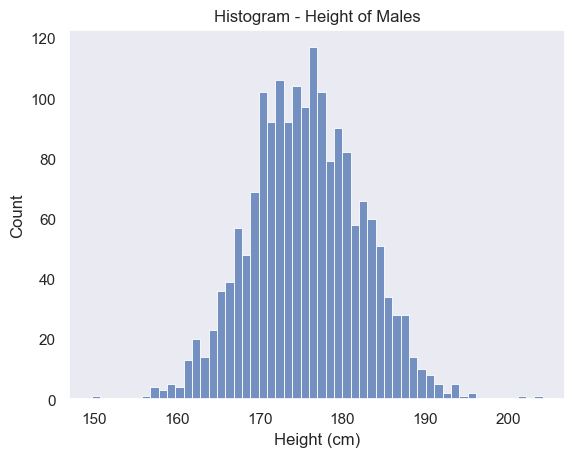

In [36]:
plt.title("Histogram - Height of Males")
plt.xlabel("Height (cm)")
plt.ylabel("Count")

# note the semicolon - it stops matplotlib from outputting ugly text about
# the graph. We set a "bin width" of 2 cm
sns.histplot(data = bmiDataset
             ,x = 'Height'
             ,binwidth=1);

#### Exercise 4: Height of Females
Please create a histogram of the height of females with a bin width of 1 cm.

### 2. Barplot

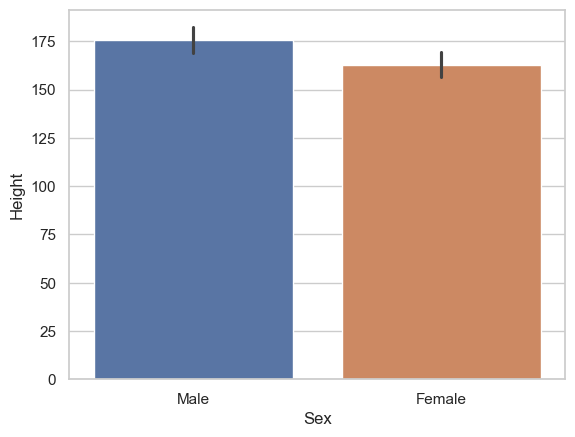

In [26]:
# barplot with an error bar showing the standard deviation
sns.barplot(data = fullFrame
            ,x = 'Sex'
            ,y = 'Height'
            ,hue = 'Sex'
            ,errorbar="sd");

#### Exercise 5: Bar Plot Comparing Weight
Please create a bar plot comparing the weight of males and females.

### 3. Box Plot

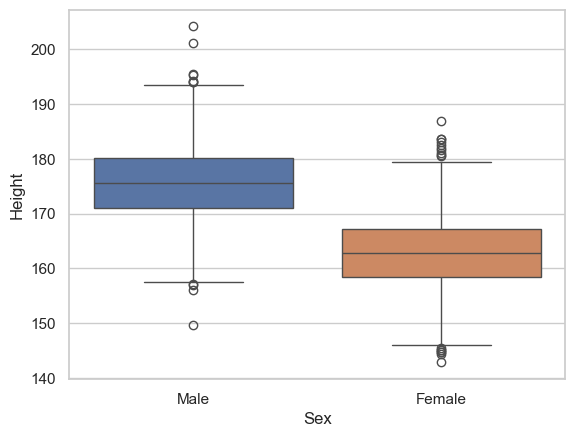

In [27]:
sns.boxplot(data = fullFrame
            ,x = 'Sex'
            ,y = 'Height'
            ,hue = 'Sex');

#### Exercise 6: Box Plot of Weight
Please create a box plot of the weight of males and females.

### 4. Scatter Plot

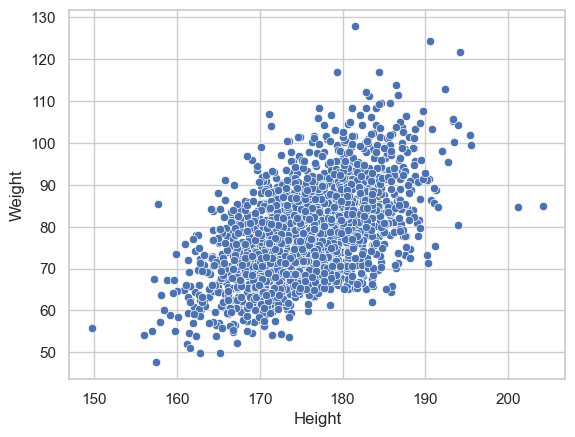

In [28]:
sns.scatterplot(data = bmiDataset
            ,x = 'Height'
            ,y = 'Weight');


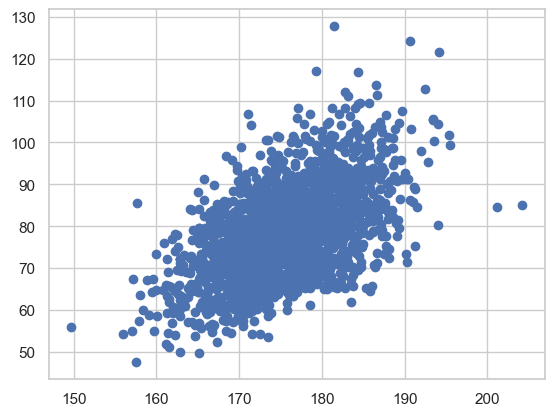

In [29]:
# Note, this is the equivalent in plain old MatPlotLib
plt.scatter(bmiDataset['Height'], bmiDataset['Weight'])
plt.show()

#### Exercise 7: Scatter Plot of Female Weight vs. Height
Please create a scatter plot of female weight vs. height.

### 5. Reg Plot

This method is used to plot data and a linear regression model fit.

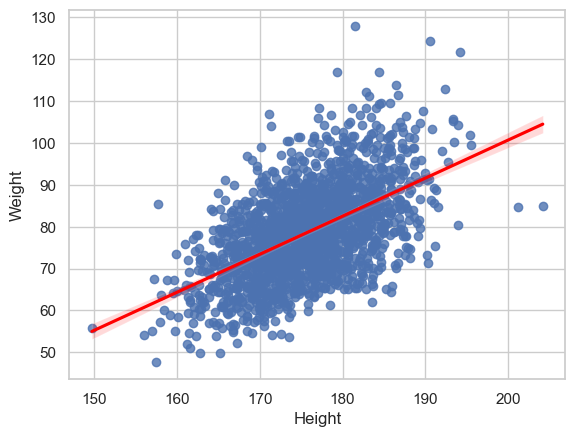

In [30]:
sns.regplot(data = bmiDataset
            ,x = 'Height'
            ,y = 'Weight'
            ,line_kws={"color":"red"});

#### Exercise 8: Reg Plot of Female Weight vs. Height
Please create a reg plot of female weight vs. height. Give it a meaningful title.

### 6. Facet Plot with Categorical Variable

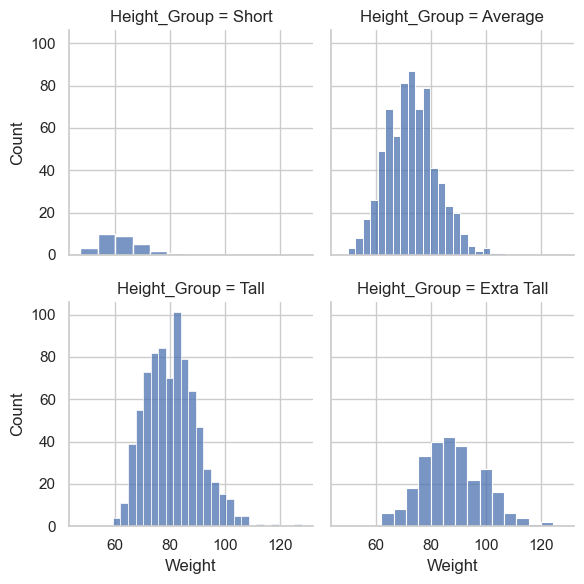

In [31]:
grid_layout = sns.FacetGrid(bmiDataset
                            ,col="Height_Group"
                            ,col_wrap = 2)
grid_layout.map(sns.histplot, 'Weight');

### 7. Facet Plot with Two Categorical Variables

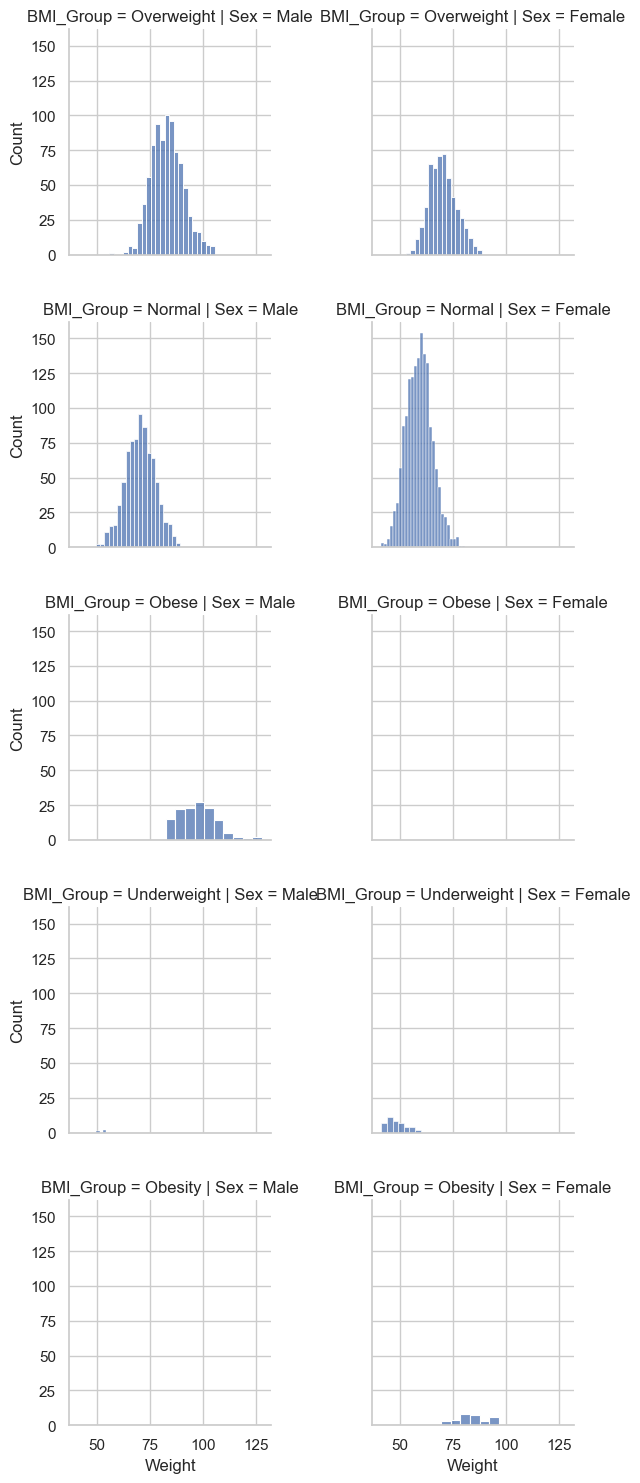

In [32]:
grid_layout = sns.FacetGrid(fullFrame
                            ,col="Sex"
                            ,row="BMI_Group")

grid_layout.map(sns.histplot, 'Weight');
grid_layout.figure.subplots_adjust(wspace=.5, hspace=.3)

### 8. Line Plot

For this one, we should load some additional data for which a line plot makes sense. In this case, five years of Amazon stock price.

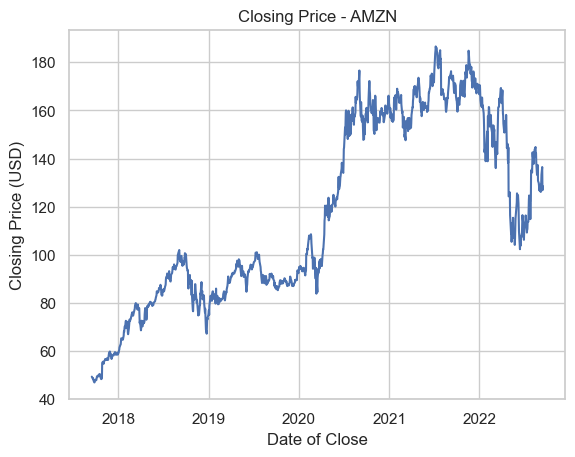

In [33]:
# Read in the data
# Tell Pandas we want to parse the "Date" column as a date
stockData = pd.read_csv(r"data/AMZN_5Year_Missing.csv",parse_dates=['Date'])

# Check it out
stockData.head()

plt.title("Closing Price - AMZN")
plt.xlabel("Date of Close")
plt.ylabel("Closing Price (USD)")
# If you want to change the limits of the graph
# X shows example with dates, Y with numberical min / max
# plt.xlim(datetime.date(2010, 1, 1),datetime.date(2024, 12, 31))
# plt.ylim(0,200)
sns.lineplot(data = stockData
             ,x = 'Date'
             ,y = 'Close');




## VII. The Power of Matplotlib

Seaborn is great, but matplotlib is what stands behind it and it is a very powerful library.

Since this is stock data, let's plot closing price in one graph and a little graph below showing the trading volume. The trading volume is the number of shares that traded hands that day. 

All the documentation for matplotlib may be found at https://matplotlib.org/stable/

In [34]:
# to plot it, since it is a time series, let's make the date the index
stockData = stockData.set_index('Date')

stockData

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-15,49.650501,49.812500,49.201500,49.339500,49.339500,75204000
2017-09-18,49.520000,49.639500,48.408501,48.709499,48.709499,68226000
2017-09-19,48.862499,48.911999,48.373001,48.493000,48.493000,53422000
2017-09-20,48.589500,48.740501,48.108002,48.660500,48.660500,57776000
2017-09-21,48.565498,48.584999,48.101002,48.232498,48.232498,46752000
...,...,...,...,...,...,...
2022-09-08,127.720001,130.279999,127.099998,129.820007,129.820007,43988500
2022-09-09,130.910004,133.690002,130.759995,133.270004,133.270004,49387600
2022-09-12,134.100006,136.490005,134.000000,136.449997,136.449997,53826900


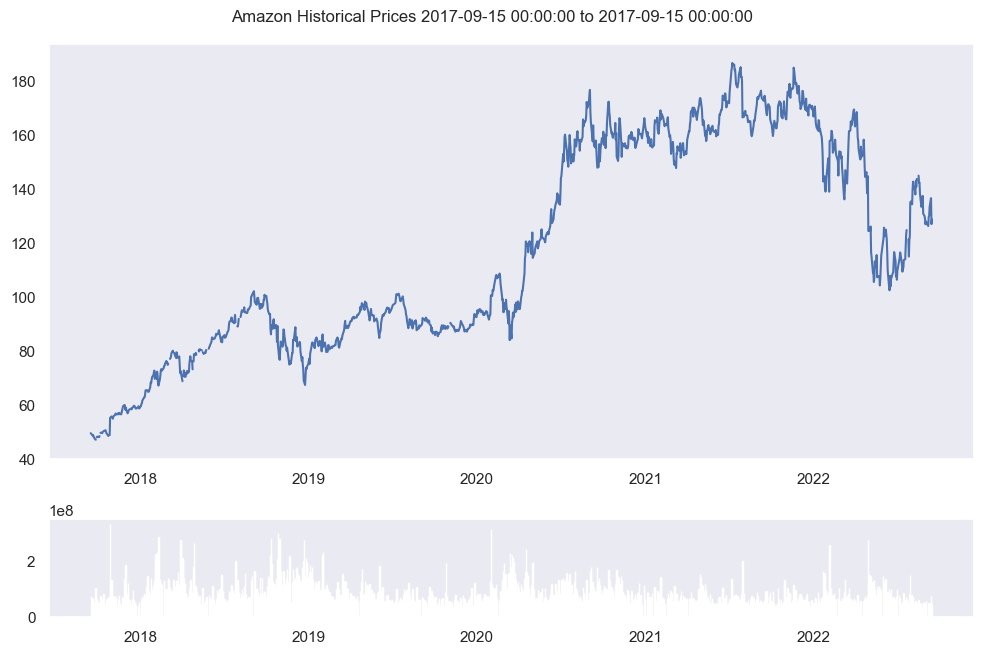

In [35]:
# Undo some of the seaborn style
sns.set_style("dark")

# First, let's make a simple "figure" that is 10 inches wide and 6 inches tall
amazonFigure = plt.figure(figsize=(10, 8),tight_layout = True)
amazonFigureTitle = 'Amazon Historical Prices ' + str(stockData.index.min()) + ' to ' + str(stockData.index.min())
amazonFigure.suptitle(amazonFigureTitle,fontsize=12)

# now, let's add a subplot to it for the Closing Price
# 5 rows x 4 cols, start at the 0th row, 0th column, and span 3 rows and 4 columns
closingPricePlot = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4, fig=amazonFigure)
closingPricePlot.plot(stockData.index, stockData['Close']);

# and let's add a subplot for the Trading Volume
# 5 rows x 4 cols, start at the 3rd row, 0th column, and span 1 row and 4 columns
volumePlot = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4, fig=amazonFigure)
volumePlot.bar(stockData.index, stockData['Volume']);